# Dimensionality Reduction in [Bayer and Luetticke (2018)](https://cepr.org/active/publications/discussion_papers/dp.php?dpno=13071)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/econ-ark/HARK/BayerLuetticke?filepath=HARK%2FBayerLuetticke%2FDCT-Copula-Illustration.ipynb)

This companion to the [main notebook](TwoAsset.ipynb) explains in more detail how the authors reduce the dimensionality of their problem

- Based on original slides by Christian Bayer and Ralph Luetticke 
- Original Jupyter notebook by Seungcheol Lee 
- Further edits by Chris Carroll, Tao Wang 


### Preliminaries

In StE in the model, in any given period, a consumer in state $s$ (which comprises liquid assets $m$, illiquid assets $k$, and human capital $\newcommand{hLev}{p}\hLev$) has two key choices:
1. To adjust ('a') or not adjust ('n') their holdings of illiquid assets $k$
1. Contingent on that choice, decide the level of consumption, yielding consumption functions:
    * $c_n(s)$ - nonadjusters
    * $c_a(s)$ - adjusters

The usual envelope theorem applies here, so marginal value wrt the liquid asset equals marginal utility with respect to consumption:
$[\frac{d v}{d m} = \frac{d u}{d c}]$.
In practice, the authors solve the problem using the marginal value of money $\texttt{Vm} = dv/dm$, but because the marginal utility function is invertible it is trivial to recover $\texttt{c}$ from $(u^{\prime})^{-1}(\texttt{Vm} )$.  The consumption function is therefore computed from the $\texttt{Vm}$ function

In [1]:
# Setup stuff

# This is a jupytext paired notebook that autogenerates a corresponding .py file
# which can be executed from a terminal command line via "ipython [name].py"
# But a terminal does not permit inline figures, so we need to test jupyter vs terminal
# Google "how can I check if code is executed in the ipython notebook"
def in_ipynb():
    try:
        if str(type(get_ipython())) == "<class 'ipykernel.zmqshell.ZMQInteractiveShell'>":
            return True
        else:
            return False
    except NameError:
        return False

# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic('matplotlib', 'inline') 
else:
    get_ipython().run_line_magic('matplotlib', 'auto') 
    
# The tools for navigating the filesystem
import sys
import os

# Find pathname to this file:
my_file_path = os.path.dirname(os.path.abspath("TwoAsset.ipynb"))

# Relative directory for pickled code
code_dir = os.path.join(my_file_path, "BayerLuetticke_code/TwoAssetCode") 

sys.path.insert(0, code_dir)
sys.path.insert(0, my_file_path)

In [2]:
# Load precalculated Stationary Equilibrium (StE) object EX3SS

import pickle
os.chdir(code_dir) # Go to the directory with pickled code

## EX3SS_20.p is the information in the stationary equilibrium 
## (20: the number of illiquid and liquid weath gridpoints)
### The comments above are original, but it seems that there are 30 not 20 points now

EX3SS=pickle.load(open("EX3SS_20.p", "rb"))

### Dimensions

The imported StE solution to the problem represents the functions at a set of gridpoints of
   * liquid assets ($n_m$ points), illiquid assets ($n_k$), and human capital ($n_h$)
   * (In the code these are $\{\texttt{nm,nk,nh}\}$)

So even if the grids are fairly sparse for each state variable, the total number of combinations of the idiosyncratic state variables is large: $n = n_m \times n_k \times n_h$.  So, e.g., $\bar{c}$ is a set of size $n$ containing the level of consumption at each possible combination of gridpoints.

In the "real" micro problem, it would almost never happen that a continuous variable like $m$ would end up being exactly equal to one of the prespecified gridpoints. But the functions need to be evaluated at such points.  This is addressed by linear interpolation.  That is, if, say, the grid had $m_{8} = 40$ and $m_{9} = 50$ then and a consumer ended up with $m = 45$ then the approximation is that $\tilde{c}(45) = 0.5 \bar{c}_{8} + 0.5 \bar{c}_{9}$.


In [3]:
# Show dimensions of the consumer's problem (state space)

print('c_n is of dimension: ' + str(EX3SS['mutil_c_n'].shape))
print('c_a is of dimension: ' + str(EX3SS['mutil_c_a'].shape))

print('Vk is of dimension:' + str(EX3SS['Vk'].shape))
print('Vm is of dimension:' + str(EX3SS['Vm'].shape))

print('For convenience, these are all constructed from the same exogenous grids:')
print(str(len(EX3SS['grid']['m']))+' gridpoints for liquid assets;')
print(str(len(EX3SS['grid']['k']))+' gridpoints for illiquid assets;')
print(str(len(EX3SS['grid']['h']))+' gridpoints for individual productivity.')
print('')
print('Therefore, the joint distribution is of size: ')
print(str(EX3SS['mpar']['nm'])+
      ' * '+str(EX3SS['mpar']['nk'])+
      ' * '+str(EX3SS['mpar']['nh'])+
      ' = '+ str(EX3SS['mpar']['nm']*EX3SS['mpar']['nk']*EX3SS['mpar']['nh']))

c_n is of dimension: (30, 30, 4)
c_a is of dimension: (30, 30, 4)
Vk is of dimension:(30, 30, 4)
Vm is of dimension:(30, 30, 4)
For convenience, these are all constructed from the same exogenous grids:
30 gridpoints for liquid assets;
30 gridpoints for illiquid assets;
4 gridpoints for individual productivity.

Therefore, the joint distribution is of size: 
30 * 30 * 4 = 3600


### Dimension Reduction

The authors use different dimensionality reduction methods for the consumer's problem and the distribution across idiosyncratic states

#### The consumer's problem: Basis Functions

The idea is to find an efficient "compressed" representation of our functions (e.g., the consumption function).  The analogy to image compression is that nearby pixels are likely to have identical or very similar colors, so we need only to find an efficient way to represent the way in which the colors change from one pixel to another.  Similarly, consumption at a given point $s_{i}$ is likely to be close to consumption point another point $s_{j}$ that is "close" in the state space (similar wealth, income, etc), so a function that captures that similarity efficiently can preserve most of the information without keeping all of the points.

Like linear interpolation, the [DCT transformation](https://en.wikipedia.org/wiki/Discrete_cosine_transform) is a method of representing a continuous function using a finite set of numbers. It uses a set of independent [basis functions](https://en.wikipedia.org/wiki/Basis_function) to do this.

But it turns out that some of those basis functions are much more important than others in representing the steady-state functions. Dimension reduction is accomplished by basically ignoring all basis functions that make small contributions to the steady state distribution.  

##### When might this go wrong?

Suppose the consumption function changes in a recession in ways that change behavior radically at some states.  Like, suppose unemployment almost never happens in steady state, but it can happen in temporary recessions.  Suppose further that, even for employed people, in a recession, _worries_ about unemployment cause many of them to prudently withdraw some of their illiquid assets -- behavior opposite of what people in the same state would be doing during expansions.  In that case, the basis functions that represented the steady state function would have had no incentive to be able to represent well the part of the space that is never seen in steady state, so any functions that might help do so might well have been dropped in the dimension reduction stage.

On the whole, it seems unlikely that this kind of thing is a major problem, because the vast majority of the variation that people experience is idiosyncratic.  There is always unemployment, for example; it just moves up and down a bit with aggregate shocks, but since the experience of unemployment is in fact well represented in the steady state the method should have no trouble capturing it.

Where the method might have more trouble is in representing economies in which there are multiple equilibria in which behavior is quite different.

#### For the distribution of agents across states: Copula

The other tool the authors use is the ["copula,"](https://en.wikipedia.org/wiki/Copula_(probability_theory)) which allows us to represent the distribution of people across idiosyncratic states efficiently

The copula is computed from the joint distribution of states in StE and will be used to transform the marginal distributions back to joint distributions.

   * In general, a multivariate joint distribution is not uniquely determined by marginal distributions only. A copula, to put it simply, is a compressed representation of the joint distribution of the rank order of points; together with the marginal distributions this expands to a complete representation of the joint distribution
   * The crucial assumption of a fixed copula is that what aggregate shocks do is to squeeze or distort the steady state distribution, but leave the rank structure of the distribution the same. Think of representing a balloon by a set of points on its surface; the copula assumption is effectively that when something happens to the balloon (more air is put in it, or it is squeezed on one side, say), we can represent what happens to the points by thinking about how the relationship between points is distorted, rather than having to reconstruct the shape of the balloon with a completely independent set of new points.  Which points are close to which other points does not change, but the distances between them can change.  If the distances between them change in a particularly simple way, you can represent what has happened with a small amount of information.  For example, if the balloon is perfectly spherical, then adding a given amount of air might increase the distances between adjacent points by 5 percent.  (See the video illustration here)
   
- In the context of this model, the assumption that allows us to use a copula is that the rank order correlation (e.g. the correlation of where you rank in the distribution of liquid assets and illiquid assets) remains the same after the aggregate shocks are introduced to StE. That is, the fact that you are richer than me, and Bill Gates is richer than you, does not change in a recession.  _How much_ richer you are than me, and Gates than you, can change, but the rank order does not.

- In this case we just need to represent how the marginal distributions of each state change, instead of the full joint distributions

- This reduces the number of points for which we need to track transitions from $3600 = 30 \times 30 \times 4$ to $64 = 30+30+4$.  Or the total number of points we need to contemplate goes from $3600^2 \approx 13 million$ to $64^2=4096$.  

In [4]:
# Get some specs about the copula, which is precomputed in the EX3SS object

print('The copula consists of two parts: gridpoints and values at those gridpoints:'+ \
      '\n gridpoints have dimensionality of '+str(EX3SS['Copula']['grid'].shape) + \
      '\n where the first element is total number of gridpoints' + \
      '\n and the second element is number of state variables' + \
      '\n whose values also are of dimension of '+str(EX3SS['Copula']['value'].shape[0]) + \
      '\n each entry of which is the probability that all three of the'
      '\n state variables are below the corresponding point.')

The copula consists of two parts: gridpoints and values at those gridpoints:
 gridpoints have dimensionality of (3600, 3)
 where the first element is total number of gridpoints
 and the second element is number of state variables
 whose values also are of dimension of 3600
 each entry of which is the probability that all three of the
 state variables are below the corresponding point.


In [5]:
## Import necessary libraries

from __future__ import print_function
import sys 
sys.path.insert(0,'../')

import numpy as np
from numpy.linalg import matrix_rank
import scipy as sc
from scipy.stats import norm 
from scipy.interpolate import interp1d, interp2d, griddata, RegularGridInterpolator, interpn
import multiprocessing as mp
from multiprocessing import Pool, cpu_count, Process
from math import ceil
import math as mt
from scipy import sparse as sp  # used to work with sparse matrices
from scipy import linalg   #linear algebra 
from math import log, cos, pi, sqrt
import time
from SharedFunc3 import Transition, ExTransitions, GenWeight, MakeGridkm, Tauchen, Fastroot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.io #scipy input and output
import scipy.fftpack as sf  # scipy discrete fourier transforms

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import seaborn as sns

In [6]:
## State reduction and discrete cosine transformation

class StateReduc_Dct:
    
    def __init__(self, par, mpar, grid, Output, targets, Vm, Vk, 
                 joint_distr, Copula, c_n_guess, c_a_guess, psi_guess,
                 m_n_star, m_a_star, cap_a_star, mutil_c_n, mutil_c_a,mutil_c, P_H):
         
        self.par = par         # Parameters of the theoretical model
        self.mpar = mpar       # Parameters of the numerical representation
        self.grid = grid       # Discrete grid
        self.Output = Output   # Results of the calculations
        self.targets = targets # Like, debt-to-GDP ratio or other desiderata
        self.Vm = Vm           # Marginal value from liquid cash-on-hand
        self.Vk = Vk           # Marginal value of capital
        self.joint_distr = joint_distr # Multidimensional histogram
        self.Copula = Copula   # Encodes rank marginal correlation of joint distribution
        self.mutil_c = mutil_c # Marginal utility of consumption
        self.P_H = P_H         # Transition matrix for macro states (not including distribution)
        
        
    def StateReduc(self):
        """
        input
        -----
        self: dict, stored results from a StE 
        
        output
        ------
        Newly generated
        ===============
        X_ss: ndarray, stacked states, including  
        Y_ss:  ndarray, controls 
        Gamma_state: ndarray, marginal distributions of individual states 
        grid: ndarray, discrete grids
        targets: ndarray, debt-to-GDP ratio or other desiderata
        P_H: transition probability of
        indexMUdct: ndarray, indices selected after dct operation on marginal utility of consumption
        indexVKdct: ndarray, indices selected after dct operation on marginal value of capital
        State: ndarray, dimension equal to reduced states
        State_m: ndarray, dimension equal to reduced states
        Contr:  ndarray, dimension equal to reduced controls
        Contr_m: ndarray, dimension equal to reduced controls
        
        Passed down from the input
        ==========================
        Copula: dict, grids and values
        joint_distr: ndarray, nk x nm x nh
        Output: dict, outputs from the model 
        par: dict, parameters of the theoretical model
        mpar:dict, parameters of the numerical representation
        aggrshock: string, type of aggregate shock used to purturb the StE 
        """
        
        # Inverse of CRRA on x for utility and marginal utility
        invutil = lambda x : ((1-self.par['xi'])*x)**(1./(1-self.par['xi'])) 
        invmutil = lambda x : (1./x)**(1./self.par['xi'])                    
            
        # X=States
        # Marg dist of liquid assets summing over pty and illiquid assets k
        Xss=np.asmatrix(np.concatenate((np.sum(np.sum(self.joint_distr.copy(),axis=1),axis =1),  
                       np.transpose(np.sum(np.sum(self.joint_distr.copy(),axis=0),axis=1)),# marg dist k
                       np.sum(np.sum(self.joint_distr.copy(),axis=1),axis=0), # marg dist pty (\approx income)
                       [np.log(self.par['RB'])],[ 0.]))).T # Given the constant interest rate
        
        # Y="controls" (according to this literature's odd terminology)
        # c = invmarg(marg(c)), so first bit gets consumption policy function
        Yss=np.asmatrix(np.concatenate((invmutil(self.mutil_c.copy().flatten(order = 'F')),\
                                        invmutil(self.Vk.copy().flatten(order = 'F')),
                      [np.log(self.par['Q'])], # Question: Price of the illiquid asset, right?
                                        [ np.log(self.par['PI'])], # Inflation
                                        [ np.log(self.Output)],    
                      [np.log(self.par['G'])], # Gov spending
                                        [np.log(self.par['W'])], # Wage
                                        [np.log(self.par['R'])], # Nominal R
                                        [np.log(self.par['PROFITS'])], 
                      [np.log(self.par['N'])], # Hours worked
                                        [np.log(self.targets['T'])], # Taxes
                                        [np.log(self.grid['K'])],    # Kapital
                      [np.log(self.targets['B'])]))).T # Government debt
        
        # Mapping for Histogram
        # Gamma_state matrix reduced set of states
        #   nm = number of gridpoints for liquid assets
        #   nk = number of gridpoints for illiquid assets
        #   nh = number of gridpoints for human capital (pty)
        Gamma_state = np.zeros( # Create zero matrix of size [nm + nk + nh,nm + nk + nh - 4]
            (self.mpar['nm']+self.mpar['nk']+self.mpar['nh'],
             self.mpar['nm']+self.mpar['nk']+self.mpar['nh'] - 4)) 
            # Question: Why 4? 4 = 3+1, 3: sum to 1 for m, k, h and 1: for entrepreneurs 

        # Impose adding-up conditions: 
        # In each of the block matrices, probabilities must add to 1
        
        for j in range(self.mpar['nm']-1): # np.squeeze reduces one-dimensional matrix to vector
            Gamma_state[0:self.mpar['nm'],j] = -np.squeeze(Xss[0:self.mpar['nm']])
            Gamma_state[j,j]=1. - Xss[j]   #   
            Gamma_state[j,j]=Gamma_state[j,j] - np.sum(Gamma_state[0:self.mpar['nm'],j])
        bb = self.mpar['nm'] # Question: bb='bottom base'? because bb shorter to type than self.mpar['nm'] everywhere

        for j in range(self.mpar['nk']-1):
            Gamma_state[bb+np.arange(0,self.mpar['nk'],1), bb+j-1] = -np.squeeze(Xss[bb+np.arange(0,self.mpar['nk'],1)])
            Gamma_state[bb+j,bb-1+j] = 1. - Xss[bb+j] 
            Gamma_state[bb+j,bb-1+j] = (Gamma_state[bb+j,bb-1+j] - 
                                        np.sum(Gamma_state[bb+np.arange(0,self.mpar['nk']),bb-1+j]))
        bb = self.mpar['nm'] + self.mpar['nk']

        for j in range(self.mpar['nh']-2): 
            # Question: Why -2?  1 for h sum to 1 and 1 for entrepreneur  Some other symmetry/adding-up condition.
            Gamma_state[bb+np.arange(0,self.mpar['nh']-1,1), bb+j-2] = -np.squeeze(Xss[bb+np.arange(0,self.mpar['nh']-1,1)])
            Gamma_state[bb+j,bb-2+j] = 1. - Xss[bb+j]
            Gamma_state[bb+j,bb-2+j] = Gamma_state[bb+j,bb-2+j] - np.sum(Gamma_state[bb+np.arange(0,self.mpar['nh']-1,1),bb-2+j])

        # Number of other state variables not including the gridded -- here, just the interest rate 
        self.mpar['os'] = len(Xss) - (self.mpar['nm']+self.mpar['nk']+self.mpar['nh'])
        # For each gridpoint there are two "regular" controls: consumption and illiquid saving
        # Counts the number of "other" controls (PROFITS, Q, etc)
        self.mpar['oc'] = len(Yss) - 2*(self.mpar['nm']*self.mpar['nk']*self.mpar['nh'])
        
        aggrshock = self.par['aggrshock']
        accuracy = self.par['accuracy']
       
        # Do the dct on the steady state marginal utility
        # Returns an array of indices for the used basis vectors
        indexMUdct = self.do_dct(invmutil(self.mutil_c.copy().flatten(order='F')),
                                 self.mpar,accuracy)

        # Do the dct on the steady state marginal value of capital
        # Returns an array of indices for the used basis vectors
        indexVKdct = self.do_dct(invmutil(self.Vk.copy()),self.mpar,accuracy)
                
        # Calculate the numbers of states and controls
        aux = np.shape(Gamma_state)
        self.mpar['numstates'] = np.int64(aux[1] + self.mpar['os'])
        self.mpar['numcontrols'] = np.int64(len(indexMUdct) + 
                                            len(indexVKdct) + 
                                            self.mpar['oc'])
        
        # Size of the reduced matrices to be used in the Fsys
        # Set to zero because in steady state they are zero
        State = np.zeros((self.mpar['numstates'],1))
        State_m = State
        Contr = np.zeros((self.mpar['numcontrols'],1))
        Contr_m = Contr
        
        return {'Xss': Xss, 'Yss':Yss, 'Gamma_state': Gamma_state, 
                'par':self.par, 'mpar':self.mpar, 'aggrshock':aggrshock,
                'Copula':self.Copula,'grid':self.grid,'targets':self.targets,'P_H':self.P_H, 
                'joint_distr': self.joint_distr, 'Output': self.Output, 'indexMUdct':indexMUdct, 'indexVKdct':indexVKdct,
                'State':State, 'State_m':State_m, 'Contr':Contr, 'Contr_m':Contr_m}

    # Discrete cosine transformation magic happens here
    # sf is scipy.fftpack tool
    def do_dct(self, obj, mpar, level):
        """
        input
        -----
        obj: ndarray nm x nk x nh  
             dimension of states before dct 
        mpar: dict
            parameters in the numerical representaion of the model, e.g. nm, nk and nh
        level: float 
               accuracy level for dct 
        output
        ------
        index_reduced: ndarray n_dct x 1 
                       an array of indices that select the needed grids after dct
                   
        """
        obj = np.reshape(obj.copy(),(mpar['nm'],mpar['nk'],mpar['nh']),order='F')
        X1 = sf.dct(obj,norm='ortho',axis=0)    # dct is operated along three dimensions axis=0/1/2
        X2 = sf.dct(X1.copy(),norm='ortho',axis=1)
        X3 = sf.dct(X2.copy(),norm='ortho',axis=2)

        # Pick the coefficients that are big
        XX = X3.flatten(order='F') 
        ind = np.argsort(abs(XX.copy()))[::-1]
        #  i will 
        i = 1    
        # Sort from smallest (=best) to biggest (=worst)
        # and count how many are 'good enough to keep'
        while linalg.norm(XX[ind[:i]].copy())/linalg.norm(XX) < level:
              i += 1    
        
        needed = i # Question:Isn't this counting the ones that are NOT needed?
        
        index_reduced = np.sort(ind[:i]) # Retrieve the good 
        
        return index_reduced

In [7]:
## Choose an aggregate shock to perturb(one of three shocks: MP, TFP, Uncertainty)

EX3SS['par']['aggrshock']           = 'MP'
EX3SS['par']['rhoS']    = 0.0      # Persistence of variance
EX3SS['par']['sigmaS']  = 0.001    # STD of variance shocks

#EX3SS['par']['aggrshock']           = 'TFP'
#EX3SS['par']['rhoS']    = 0.95
#EX3SS['par']['sigmaS']  = 0.0075
    
#EX3SS['par']['aggrshock']           = 'Uncertainty'
#EX3SS['par']['rhoS']    = 0.84    # Persistence of variance
#EX3SS['par']['sigmaS']  = 0.54    # STD of variance shocks

In [8]:
## Choose an accuracy of approximation with DCT
### Determines number of basis functions chosen -- enough to match this accuracy
### EX3SS is precomputed steady-state pulled in above
EX3SS['par']['accuracy'] = 0.99999 

## 20190607: CDC to TW: Please try to figure out what this is

In [9]:
## Implement state reduction and DCT
### Do state reduction on steady state
EX3SR=StateReduc_Dct(**EX3SS)   # Takes StE result as input and get ready to invoke state reduction operation
SR=EX3SR.StateReduc()           # StateReduc is operated 

In [10]:
# Measuring the effectiveness of the state reduction

print('What are the results from the state reduction?')
#print('Newly added attributes after the operation include \n'+str(set(SR.keys())-set(EX3SS.keys())))

print('\n')

print('To achieve an accuracy of '+str(EX3SS['par']['accuracy'])+'\n') 

print('The dimension of the policy functions is reduced to '+str(SR['indexMUdct'].shape[0]) \
      +' from '+str(EX3SS['mpar']['nm']*EX3SS['mpar']['nk']*EX3SS['mpar']['nh'])
      )
print('The dimension of the marginal value functions is reduced to '+str(SR['indexVKdct'].shape[0]) \
      + ' from ' + str(EX3SS['Vk'].shape))
print('The total number of control variables is '+str(SR['Contr'].shape[0])+'='+str(SR['indexMUdct'].shape[0]) + \
      '+'+str(SR['indexVKdct'].shape[0])+'+ # of other macro controls')
print('\n')
print('The copula represents the joint distribution with a vector of size '+str(SR['Gamma_state'].shape) )
print('The dimension of states including exogenous state, is ' +str(SR['Xss'].shape[0]))

print('It simply stacks all grids of different\
      \n state variables regardless of their joint distributions.\
      \n This is due to the assumption that the rank order remains the same.')
print('The total number of state variables is '+str(SR['State'].shape[0]) + '='+\
     str(SR['Gamma_state'].shape[1])+'+ the number of macro states (like the interest rate)')

What are the results from the state reduction?


To achieve an accuracy of 0.99999

The dimension of the policy functions is reduced to 154 from 3600
The dimension of the marginal value functions is reduced to 94 from (30, 30, 4)
The total number of control variables is 259=154+94+ # of other macro controls


The copula represents the joint distribution with a vector of size (64, 60)
The dimension of states including exogenous state, is 66
It simply stacks all grids of different      
 state variables regardless of their joint distributions.      
 This is due to the assumption that the rank order remains the same.
The total number of state variables is 62=60+ the number of macro states (like the interest rate)


### Graphical Illustration

#### Policy/value functions

Taking the consumption function as an example, we plot consumption by adjusters and non-adjusters over a range of $k$ and $m$ that encompasses x percent of the mass of the distribution function.  

We plot the functions for the top and bottom values of the wage $h$ distribution


In [58]:
## Graphical illustration

###   In 2D, we can look at how the number of grid points of 
###     one state is redcued at given grid values of other states. 

mgrid_fix = 0    ## these are or arbitrary grid points.
kgrid_fix = 0
hgrid_fix = 2


xi = EX3SS['par']['xi']

invmutil = lambda x : (1./x)**(1./xi)  

### convert marginal utilities back to consumption function
mut_StE  =  EX3SS['mutil_c']
mut_n_StE = EX3SS['mutil_c_n']    # marginal utility of non-adjusters
mut_a_StE = EX3SS['mutil_c_a']   # marginal utility of adjusters 

c_StE = invmutil(mut_StE)
cn_StE = invmutil(mut_n_StE)
ca_StE = invmutil(mut_a_StE)


### grid values 
dim_StE = mut_StE.shape
mgrid = EX3SS['grid']['m']
kgrid = EX3SS['grid']['k']
hgrid = EX3SS['grid']['h']

## indexMUdct is one dimension, needs to be unraveled to 3 dimensions

mut_rdc_idx = np.unravel_index(SR['indexMUdct'],dim_StE,order='F')

## these are filtered indices for the fixed grids of other two states 

mgrid_rdc = mut_rdc_idx[0][(mut_rdc_idx[1]==kgrid_fix) & (mut_rdc_idx[2]==hgrid_fix)]
kgrid_rdc = mut_rdc_idx[1][(mut_rdc_idx[0]==mgrid_fix) & (mut_rdc_idx[2]==hgrid_fix)]
hgrid_rdc = mut_rdc_idx[2][(mut_rdc_idx[0]==mgrid_fix) & (mut_rdc_idx[1]==kgrid_fix)]


## get the 95 percent or other percentile of the distribution


joint_distr =  EX3SS['joint_distr']
marginal_mk =  EX3SS['joint_distr'].sum(axis=2)

mass_pct = 0.1

[0.07200375 0.01031876 0.01169069 0.01359939 0.01614091 0.017144
 0.01857308 0.01810519 0.0176806  0.01578857 0.01319908 0.00992885
 0.00759158 0.00613664 0.00560593 0.00581903 0.00619134 0.00647086
 0.00690205 0.00705841 0.00730674 0.00717626 0.00685939 0.00614469
 0.00550347 0.00420646 0.00328828 0.00199992 0.00112857 0.00049545]
-1.85
[0.05052011 0.00900058 0.01093167 0.01253748 0.01619199 0.01765993
 0.02109494 0.02134474 0.02150902 0.0200873  0.01705809 0.01255788
 0.00925782 0.00703575 0.00596066 0.00603446 0.00640771 0.00670134
 0.00712854 0.00726678 0.00754573 0.00739173 0.00707725 0.00634633
 0.00569161 0.00436494 0.00341954 0.00210166 0.00118557 0.00054037]
-1.85
[0.03169237 0.00647038 0.0085406  0.0101279  0.01395919 0.01728227
 0.02214044 0.02450437 0.02605768 0.02472883 0.02252797 0.01626099
 0.01156847 0.00824193 0.00636855 0.00621372 0.00660495 0.00680418
 0.00721907 0.00735598 0.00757752 0.00741547 0.00707563 0.00630792
 0.00565156 0.00430859 0.00334391 0.00205486 0.001

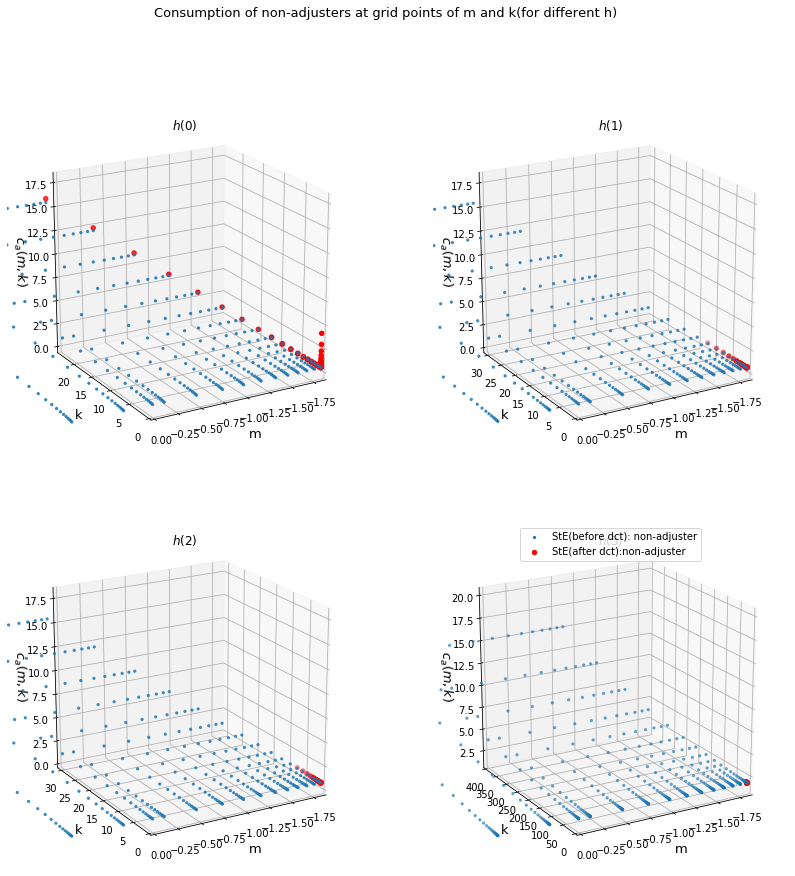

In [59]:
## 3D scatter plots of consumption function 
##    at all grids and grids after dct for both adjusters and non-adjusters

## full grids 
mmgrid,kkgrid = np.meshgrid(mgrid,kgrid)


### for adjusters 
fig = plt.figure(figsize=(14,14))
fig.suptitle('Consumption of non-adjusters at grid points of m and k(for different h)',
             fontsize=(13))
for hgrid_id in range(EX3SS['mpar']['nh']):
    ## prepare the reduced grids 
    hgrid_fix=hgrid_id
    fix_bool = mut_rdc_idx[2]==hgrid_fix  # for a fixed h grid value 
    rdc_id = (mut_rdc_idx[0][fix_bool], 
              mut_rdc_idx[1][fix_bool],
              mut_rdc_idx[2][fix_bool])
    mmgrid_rdc = mmgrid[rdc_id[0]].T[0]
    kkgrid_rdc = kkgrid[rdc_id[1]].T[0]
    mut_n_rdc= mut_n_StE[rdc_id]
    c_n_rdc = cn_StE[rdc_id]
    c_a_rdc = ca_StE[rdc_id]
    marginal_mk = joint_distr[:,:,hgrid_fix]
    marginal_m = marginal_mk.sum(axis=0)
    print(marginal_m)
    marginal_k = marginal_mk.sum(axis=1)
    mmax = mgrid[(np.abs(marginal_m-mass_pct)).argmin()]
    kmax = kgrid[(np.abs(marginal_k-mass_pct)).argmin()]
    
    print(mmax)
    ## plots 
    ax = fig.add_subplot(2,2,hgrid_id+1, projection='3d')
    ax.scatter(mmgrid,kkgrid,cn_StE[:,:,hgrid_fix],marker='.',
               label='StE(before dct): non-adjuster')
    ax.scatter(mmgrid_rdc,kkgrid_rdc,c_n_rdc,c='red',marker='o',
               label='StE(after dct):non-adjuster')
    ax.set_xlabel('m',fontsize=13)
    ax.set_ylabel('k',fontsize=13)
    ax.set_zlabel(r'$c_a(m,k)$',fontsize=13)
    
    ax.set_xlim([0,mmax])
    ax.set_ylim([0,kmax])
    ax.set_title(r'$h({})$'.format(hgrid_fix))
    ax.view_init(20, 240)
ax.legend(loc=9)

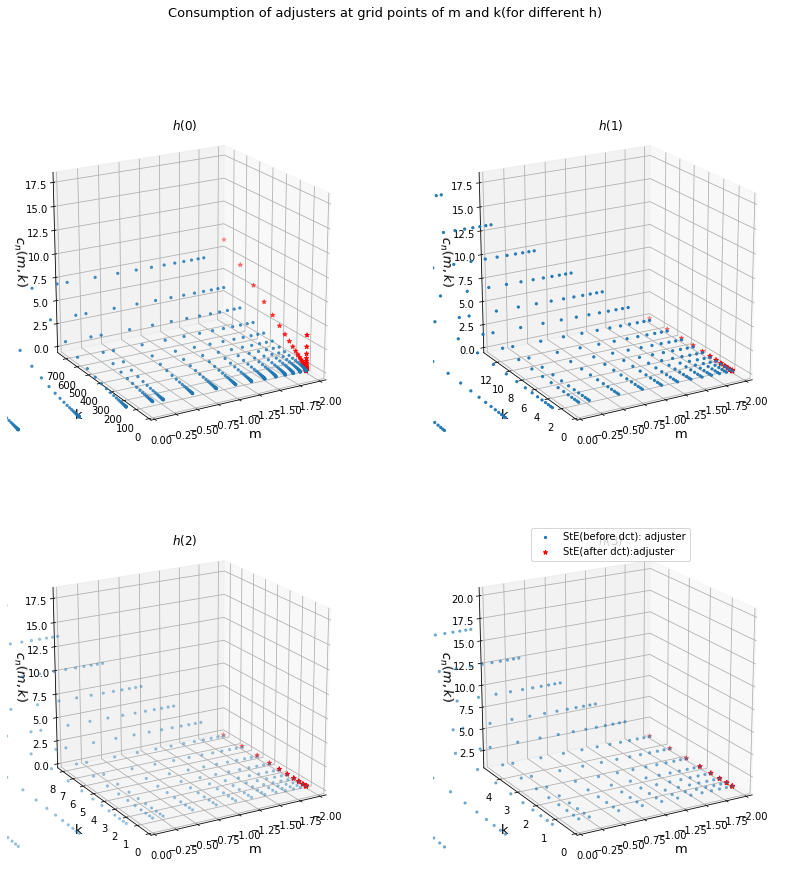

In [13]:
### for adjusters 
fig = plt.figure(figsize=(14,14))
fig.suptitle('Consumption of adjusters at grid points of m and k(for different h)',
             fontsize=(13))
for hgrid_id in range(EX3SS['mpar']['nh']):
    ## prepare the reduced grids 
    hgrid_fix=hgrid_id
    fix_bool = mut_rdc_idx[2]==hgrid_fix  # for a fixed h grid value 
    rdc_id = (mut_rdc_idx[0][fix_bool], 
              mut_rdc_idx[1][fix_bool],
              mut_rdc_idx[2][fix_bool])
    mmgrid_rdc = mmgrid[rdc_id[0]].T[0]
    kkgrid_rdc = kkgrid[rdc_id[1]].T[0]
    mut_n_rdc= mut_n_StE[rdc_id]
    c_n_rdc = cn_StE[rdc_id]
    c_a_rdc = ca_StE[rdc_id]
    mmax = mmgrid_rdc.max()
    kmax = kkgrid_rdc.max()
    
    ## plots 
    ax = fig.add_subplot(2,2,hgrid_id+1, projection='3d')
    ax.scatter(mmgrid,kkgrid,ca_StE[:,:,hgrid_fix],marker='.',
               label='StE(before dct): adjuster')
    ax.scatter(mmgrid_rdc,kkgrid_rdc,c_a_rdc,c='red',marker='*',
               label='StE(after dct):adjuster')
    ax.set_xlabel('m',fontsize=13)
    ax.set_ylabel('k',fontsize=13)
    ax.set_zlabel(r'$c_n(m,k)$',fontsize=13)
    ax.set_xlim([0,mmax*1.1])
    ax.set_ylim([0,kmax*1.2])
    ax.set_title(r'$h({})$'.format(hgrid_fix))
    ax.view_init(20, 240)
ax.legend(loc=9)

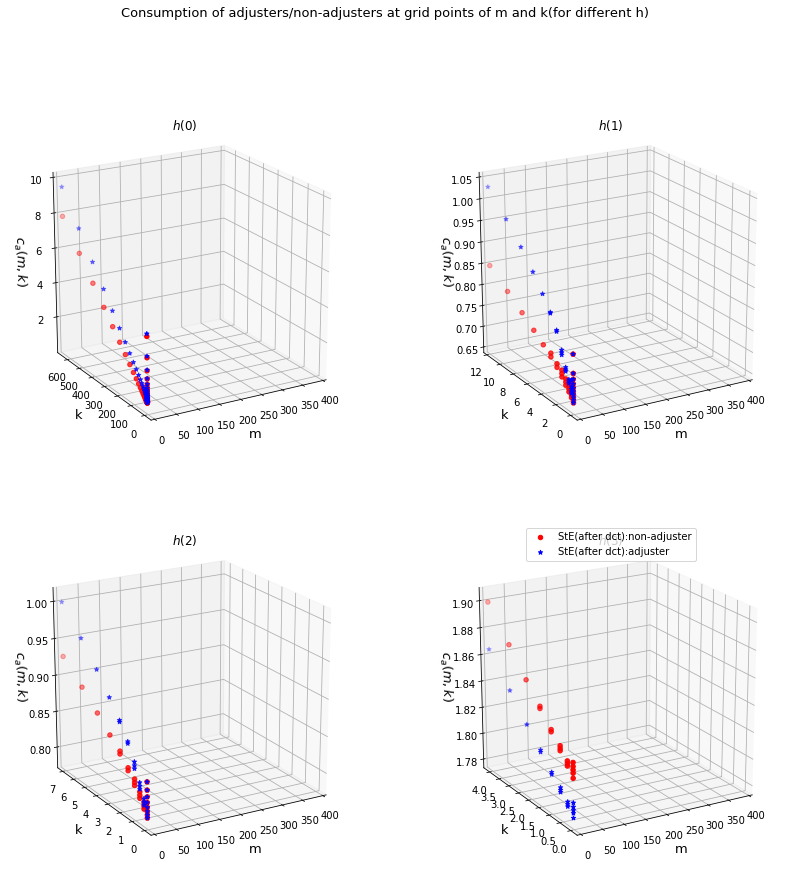

In [14]:
### compare adjusters and non-adjusters after DCT

fig = plt.figure(figsize=(14,14))
fig.suptitle('Consumption of adjusters/non-adjusters at grid points of m and k(for different h)',
             fontsize=(13))
for hgrid_id in range(EX3SS['mpar']['nh']):
    ## prepare the reduced grids 
    hgrid_fix=hgrid_id
    fix_bool = mut_rdc_idx[2]==hgrid_fix  # for a fixed h grid value 
    rdc_id = (mut_rdc_idx[0][fix_bool], 
              mut_rdc_idx[1][fix_bool],
              mut_rdc_idx[2][fix_bool])
    mmgrid_rdc = mmgrid[rdc_id[0]].T[0]
    kkgrid_rdc = kkgrid[rdc_id[1]].T[0]
    mut_n_rdc= mut_n_StE[rdc_id]
    c_n_rdc = cn_StE[rdc_id]
    c_a_rdc = ca_StE[rdc_id]
    
    ## plots 
    ax = fig.add_subplot(2,2,hgrid_id+1, projection='3d')
    #ax.scatter(mmgrid,kkgrid,cn_StE[:,:,hgrid_fix],marker='.',
    #           label='StE(before dct): non-adjuster')
    #ax.scatter(mmgrid,kkgrid,ca_StE[:,:,hgrid_fix],c='yellow',marker='.',
    #           label='StE(before dct): adjuster')
    ax.scatter(mmgrid_rdc,kkgrid_rdc,c_n_rdc,c='red',marker='o',
               label='StE(after dct):non-adjuster')
    ax.scatter(mmgrid_rdc,kkgrid_rdc,c_a_rdc,c='blue',marker='*',
               label='StE(after dct):adjuster')
    ax.set_xlabel('m',fontsize=13)
    ax.set_ylabel('k',fontsize=13)
    ax.set_zlabel(r'$c_a(m,k)$',fontsize=13)
    ax.set_title(r'$h({})$'.format(hgrid_fix))
    ax.set_xlim(0,400)
    ax.view_init(20, 240)
ax.legend(loc=9)

##### Observation

- For a given grid value of productivity, the remaining grid points after DCT to represent the whole consumption function are concentrated in low values of $k$ and $m$. This is because the slopes of the surfaces of marginal utility are changing the most in these regions.  For larger values of $k$ and $m$ the functions become smooth and only slightly concave, so they can be represented by many fewer points
- For different grid values of productivity (2 sub plots), the numbers of grid points in the DCT operation differ. From the lowest to highest values of productivity, there are 78, 33, 25 and 18 grid points, respectively. They add up to the total number of gridpoints of 154 after DCT operation, as we noted above for marginal utility function. 

#### Distribution of states 

- We first plot the distribution of $k$ fixing $m$ and $h$. Next, we plot the joint distribution of $m$ and $k$ only fixing $h$ in 3-dimenstional space.  
- The joint-distribution can be represented by marginal distributions of $m$, $k$ and $h$ and a copula that describes the correlation between the three states. The former is straightfoward. We plot the copula only. The copula is essentially a multivariate cummulative distribution function where each marginal is uniform. (Translation from the uniform to the appropriate nonuniform distribution is handled at a separate stage).


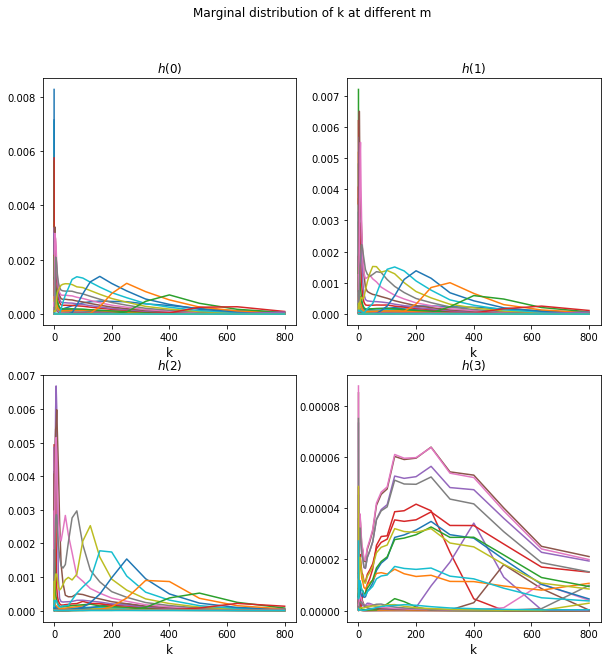

In [15]:
### Marginalize along h grids

joint_distr =  EX3SS['joint_distr']
joint_distr_km = EX3SS['joint_distr'].sum(axis=2)

### Plot distributions in 2 dimensional graph 

fig = plt.figure(figsize=(10,10))
plt.suptitle('Marginal distribution of k at different m')

for hgrid_id in range(EX3SS['mpar']['nh']):
    ax = plt.subplot(2,2,hgrid_id+1)
    ax.set_title(r'$h({})$'.format(hgrid_id))
    ax.set_xlabel('k',size=12)
    for id in range(EX3SS['mpar']['nm']):   
        ax.plot(kgrid,joint_distr[id,:,hgrid_id])

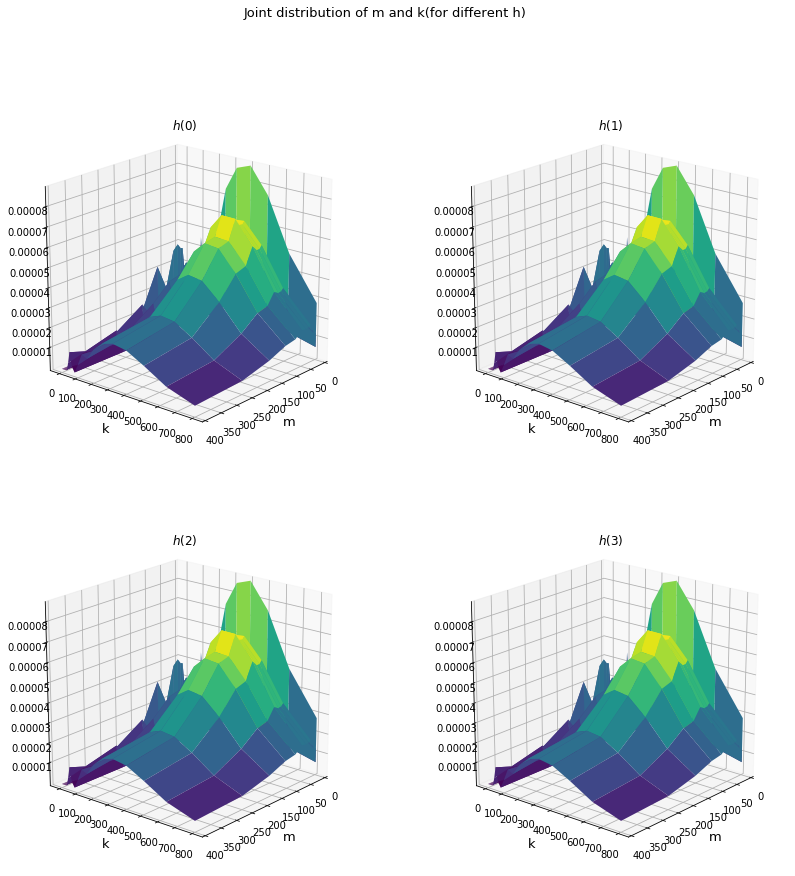

In [16]:
## Plot joint distribution of k and m in 3d graph

fig = plt.figure(figsize=(14,14))
fig.suptitle('Joint distribution of m and k(for different h)',
             fontsize=(13))
for hgrid_id in range(EX3SS['mpar']['nh']):
    ## plots 
    ax = fig.add_subplot(2,2,hgrid_id+1, projection='3d')
    ax.plot_surface(mmgrid,kkgrid,joint_distr[:,:,hgrid_fix], rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    ax.set_xlabel('m',fontsize=13)
    ax.set_ylabel('k',fontsize=13)
    #ax.set_zlabel(r'$p(m,k)$',fontsize=10)
    ax.set_title(r'$h({})$'.format(hgrid_id))
    ax.set_xlim(0,400)
    ax.view_init(20, 40)

Notice the CDFs in StE copula have 4 modes, corresponding to the number of $h$ gridpoints. Each of the four parts of the cdf is a joint-distribution of $m$ and $k$.  It can be presented in 3-dimensional graph as below.  

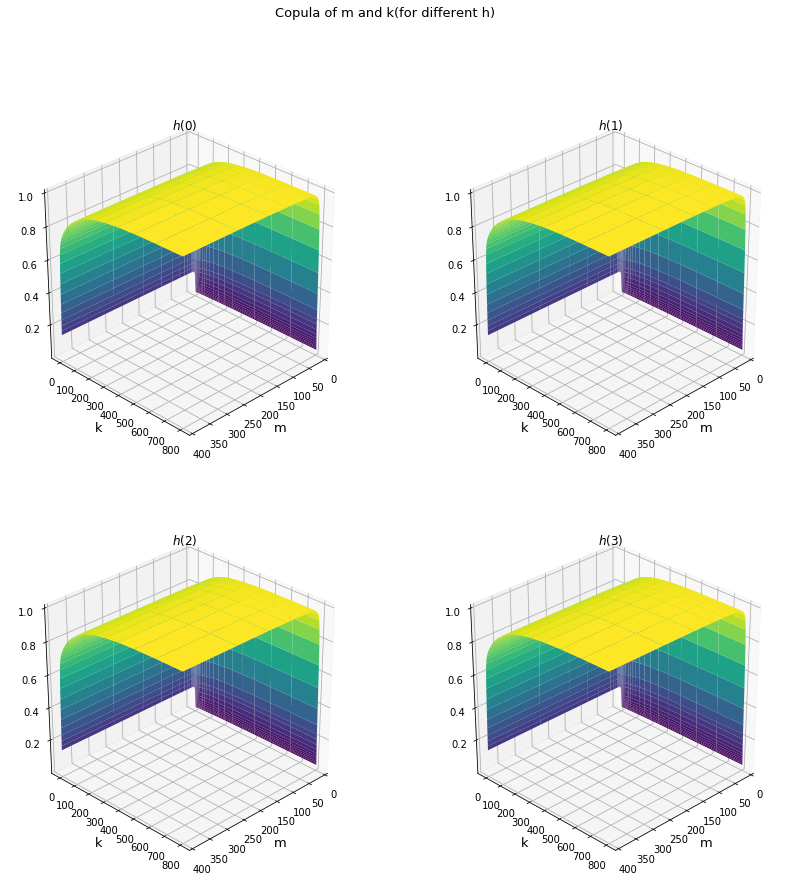

In [17]:
## Plot the copula 

cdf=EX3SS['Copula']['value'].reshape(4,30,30)   # important: 4,30,30 not 30,30,4? 

fig = plt.figure(figsize=(14,14))
fig.suptitle('Copula of m and k(for different h)',
             fontsize=(13))
for hgrid_id in range(EX3SS['mpar']['nh']):
    ## plots 
    ax = fig.add_subplot(2,2,hgrid_id+1, projection='3d')
    ax.plot_surface(mmgrid,kkgrid,cdf[hgrid_fix,:,:], rstride=1, cstride=1,
                    cmap='viridis', edgecolor='None')
    ax.set_xlabel('m',fontsize=13)
    ax.set_ylabel('k',fontsize=13)
    ax.set_title(r'$h({})$'.format(hgrid_id))
    ax.set_xlim(0,400)
    ax.view_init(30, 45)

Given the assumption that the copula remains the same after aggregate risk is introduced, we can use the same copula and the marginal distributions to recover the full joint-distribution of the states.  

### Summary: what do we achieve after the transformation?

- Using the DCT, the dimension of the policy and value functions are reduced from 3600 to 154 and 94, respectively.
- By marginalizing the joint distribution with the fixed copula assumption, the marginal distribution is of dimension 64 compared to its joint distribution of a dimension of 3600.


